# Word of the day: Productionising

The initial concept was quite simple: gather all the requirements in one place, define a builder class and save it for the future. Then few hundred lines of code later and few weeks into integration we thought: why not make it scikit-learn compatible, so you can have your 2 fav libraries and functions compliment each other? So here we are now, but let’s start from the beginning:


Recent release of PyMC-Marketing by Labs proves to be a big hit [check here <-](https://www.pymc-labs.io/blog-posts/pymc-marketing-a-bayesian-approach-to-marketing-data-science/). In the feedback one could see an ongoing theme, many of you have been requesting easy and robust way of deploying models to production. It’s been a long-standing problem with PyMC ( and most other PPLs). The reason for that is that there’s no obvious way, and doesn’t matter which approach you try it proves to be tricky. Fortunately neither me nor PyMC-Labs likes obvious solutions, and because of that we’re happy to announce the release of ModelBuilder, brand new PyMC-experimental module that addresses this need, and improves on the deployment process significantly.


For this notebook I'll use the example model used in [MMM Example Notebook](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html), but ommit the details of data generation and plotting functionalities, since they're out of scope for this introduction, I highly recommend to see that part as well, but for now let's focus on today's topic: ModelBuilder and it's recent integration with PyMC-Marketing toolset.
The reason for choosing DelayedSaturatedMMM is that MMM classes make use of most of features provided in the project, including sklearn-like API

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

Let's generate the data:

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)
n = df.shape[0]


In [3]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [5]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

## _Trend & Seasonal Components_

In [6]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

##  _Control Variables_
We add two events where there was a remarkable peak in our target variable. We assume they are independent an not seasonal (e.g. launch of a particular product).



In [7]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

## _Defining Target Variable_

In [8]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)


Previous code cells have given us our final dataset:

In [9]:
df

,date_week,year,month,dayofyear,x1,x2,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,epsilon,y
0,2018-04-02,2018,4,92,0.318580,0.000000,0.191273,0.000000,0.364917,0.000000,0.778279,0.021487,-0.010744,0.005371,0.0,0.0,2.0,0.106260,3.984662
1,2018-04-09,2018,4,99,0.112388,0.000000,0.143987,0.000000,0.280268,0.000000,0.790638,0.259165,-0.130704,0.064231,0.0,0.0,2.0,0.067198,3.762872
2,2018-04-16,2018,4,106,0.292400,0.000000,0.233150,0.000000,0.435205,0.000000,0.802746,0.481904,-0.248773,0.116566,0.0,0.0,2.0,0.242042,4.466967
3,2018-04-23,2018,4,113,0.071399,0.000000,0.136127,0.000000,0.265721,0.000000,0.814614,0.676865,-0.363245,0.156810,0.0,0.0,2.0,0.095631,3.864219
4,2018-04-30,2018,4,120,0.386745,0.000000,0.286650,0.000000,0.517779,0.000000,0.826254,0.832810,-0.472462,0.180174,0.0,0.0,2.0,-0.118140,4.441625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-08-02,2021,8,214,0.033024,0.000000,0.056235,0.001163,0.111998,0.001745,1.770035,-0.879312,-0.859141,-0.869226,0.0,0.0,2.0,0.313255,3.553546
175,2021-08-09,2021,8,221,0.165615,0.863349,0.121870,0.690914,0.239025,0.776451,1.773333,-0.967484,-0.791496,-0.879490,0.0,0.0,2.0,0.401690,5.565510
176,2021-08-16,2021,8,228,0.171882,0.000000,0.151917,0.138183,0.294818,0.204356,1.776620,-0.999887,-0.712405,-0.856146,0.0,0.0,2.0,-0.075989,4.137651
177,2021-08-23,2021,8,235,0.280257,0.000000,0.228954,0.027637,0.428377,0.041431,1.779895,-0.974654,-0.623010,-0.798832,0.0,0.0,2.0,0.129986,4.479041


But for our model we need much smaller dataset, many of the previous features were contributing to generation of others, now as our target variable is computed we can filter out not needed columns:

In [10]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
# trend feature
data["t"] = range(n)
data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120,4


## _Model Creation_
After we have our dataset ready, we could proceed straight to our model definition, but first to show the full potential of one of the new features of ModelBuilder - model_config we need to use some of our data to define our prior for sigma parameter for each of the channels. Model_config is a customizable dictionary with keys corresponding to priors within the model, and values containing a dictionaries with parameters necesary to initialise them. Later on we'll learn that through 'save' function we can preserve our priors contained inside model_config, to allow complete replication of our model.

First, let's compute the share of spend per channel:

In [11]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

Next, we specify the sigma parameter per channel:

In [12]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1775326025486734, 1.1402608773919387]

'default_model_config' attribute of every model inheriting from ModelBuilder will allow you to see which priors are available for customization. To see it simply initialize dummy model:

In [13]:
dummy_model = DelayedSaturatedMMM(date_column = '', channel_columns= '', adstock_max_lag = 4)
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

You can change only the prior parameters that you wish, no need to alter all of them, unless you'd like to!
In this case we'll just simply replace our sigma for beta_channel with our computed one:

In [14]:
custom_beta_channel_prior = {'beta_channel': {'sigma': prior_sigma, 'dims': ('channel',)}}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}

As mentioned in the original notebook: "_For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the DelayedSaturatedMMM class has some default priors that you can use as a starting point._"

Second feature that we can use for model definition is sampler_config. Similarily to model_config it's a dictionary that gets saved, and it contains things you'd usually pass to fit() kwargs. It's not mandatory to create your own sampler_config, if not provided both model_config and sampler_config will default to their form specified by PyMC Labs experts, that allows usage of all models functionalities. Default sampler config is left empty as default sampling parameters usually prove good enough for start.

In [15]:
dummy_model.default_sampler_config

{}

In [24]:
my_sampler_config = {
    'tune':1000,
    'draws':1000,
}

Let's finally assemble our model!

In [25]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = my_sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

Important thing to notice here, is that in new version of DelayedSaturatedMMM we don't pass our dataset to the class constructor itself. It is caused by something I've mentioned before - support for scikit-learn transformers and validations, that require usual X,y split, and usually expect the data to be passed to fit() function.

## _X, y Splitting:_

In [26]:
X = data.drop('y',axis=1)
y = data['y']

## _Model Fitting_

All that's left now is to finally fit the model:

In [27]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [alpha, beta_channel, gamma_control, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

Fit function from ModelBuilder automatically builds the model using the priors from model_config, and assigns the created model to our instance. You can access it as a normal attribute.

In [28]:
type(mmm.model)

pymc.model.Model

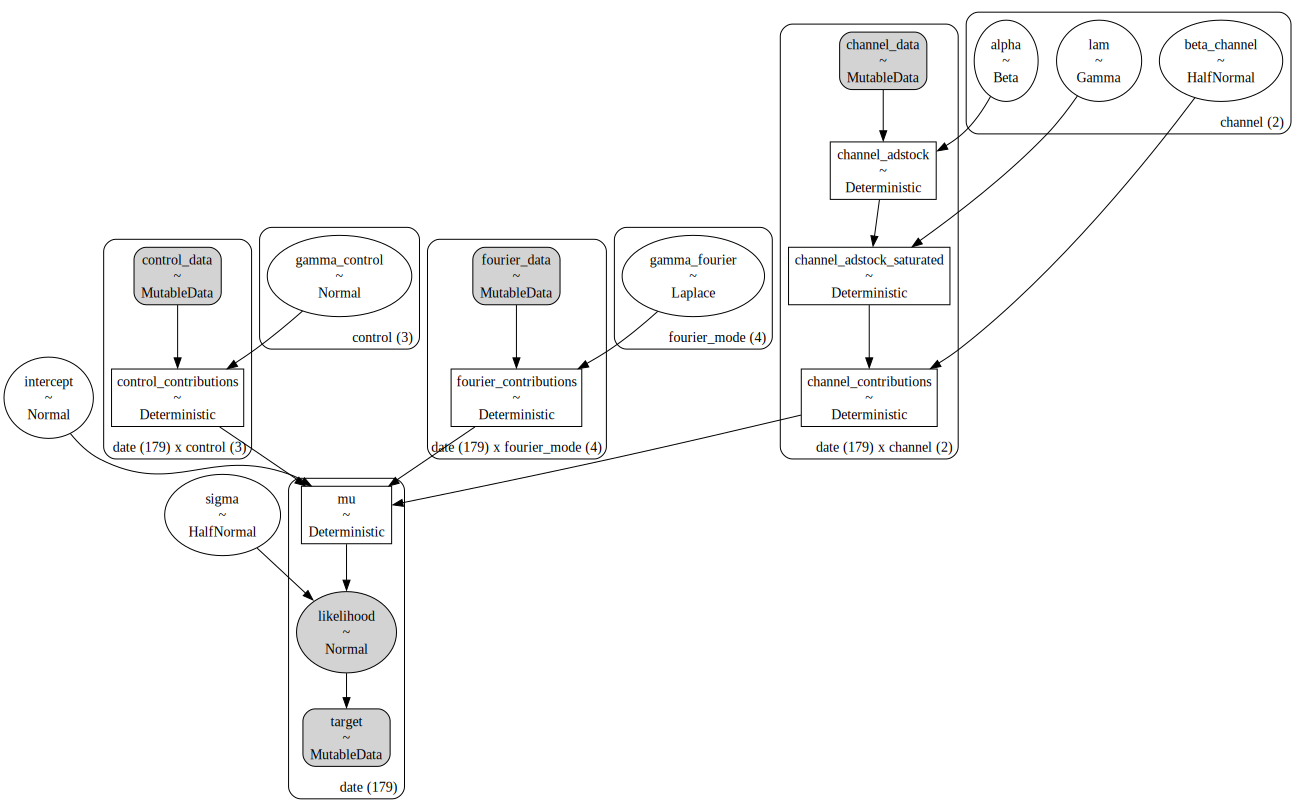

In [43]:
mmm.graphviz()

posterior trace can be accessed `fit_result` attribute

In [30]:
mmm.fit_result

<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 3,
                                fourier_mode: 4, channel: 2, date: 179)
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U7 'event_1' 'event_2' 't'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U2 'x1' 'x2'
  * date                       (date) datetime64[ns] 2018-04-02 ... 2021-08-30
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.3344 0.3594 ... 0.3314
    gamma_control              (chain, draw, control) float64 0.2057 ... 0.00...
    gamma_fourier              (chain, draw, fourier_mode) float64 0.008332 ....
    beta_channel               (chain, draw, channel) float64 0.3785 ... 0.2582
    alpha                      (chain, draw, channel) float64 0.3989 ... 0.2087
    lam                        (chain, draw, channel) float64 4.166 ... 2.632
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.1923 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.3804 .....
    channel_contributions      (chain, draw, date, channel) float64 0.144 ......
    control_contributions      (chain, draw, date, control) float64 0.0 ... 0...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 0.00...
    mu                         (chain, draw, date) float64 0.4845 ... 0.5767
Attributes:
    created_at:                 2023-07-12T14:38:39.100887
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.0
    sampling_time:              30.91073203086853
    tuning_steps:               1000

And if you wish to inspect the entire inference data, use `idata` attribute. Within idata, our entire dataset passed to the model can be found under `fit_data`

In [31]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

All the data passed to the model on initialisation is stored in idata.attrs. It will be later used in save() function to convert them, and all the fit data into netcdf format.

In [32]:
mmm.idata.attrs

{'id': 'd399aa1e9f85a3f4',
 'model_type': 'DelayedSaturatedMMM',
 'version': '0.0.2',
 'sampler_config': '{"tune": 1000, "draws": 1000}',
 'model_config': '{"intercept": {"mu": 0, "sigma": 2}, "beta_channel": {"sigma": [2.1775326025486734, 1.1402608773919387], "dims": ["channel"]}, "alpha": {"alpha": 1, "beta": 3, "dims": ["channel"]}, "lam": {"alpha": 3, "beta": 1, "dims": ["channel"]}, "sigma": {"sigma": 2}, "gamma_control": {"mu": 0, "sigma": 2, "dims": ["control"]}, "mu": {"dims": ["date"]}, "likelihood": {"dims": ["date"]}, "gamma_fourier": {"mu": 0, "b": 1, "dims": "fourier_mode"}}',
 'date_column': '"date_week"',
 'control_columns': '["event_1", "event_2", "t"]',
 'channel_columns': '["x1", "x2"]',
 'adstock_max_lag': '8',
 'validate_data': 'true',
 'yearly_seasonality': '2'}

Simply specify path to which you'd like to save your model:

In [33]:
mmm.save('my_saved_model')

And pass it to load() function when it's needed again on the target system:

In [34]:
loaded_model = DelayedSaturatedMMM.load('my_saved_model')

/Users/michalraczycki/Documents/pymc-marketing/.conda/envs/marketing_env/lib/python3.11/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [35]:
loaded_model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

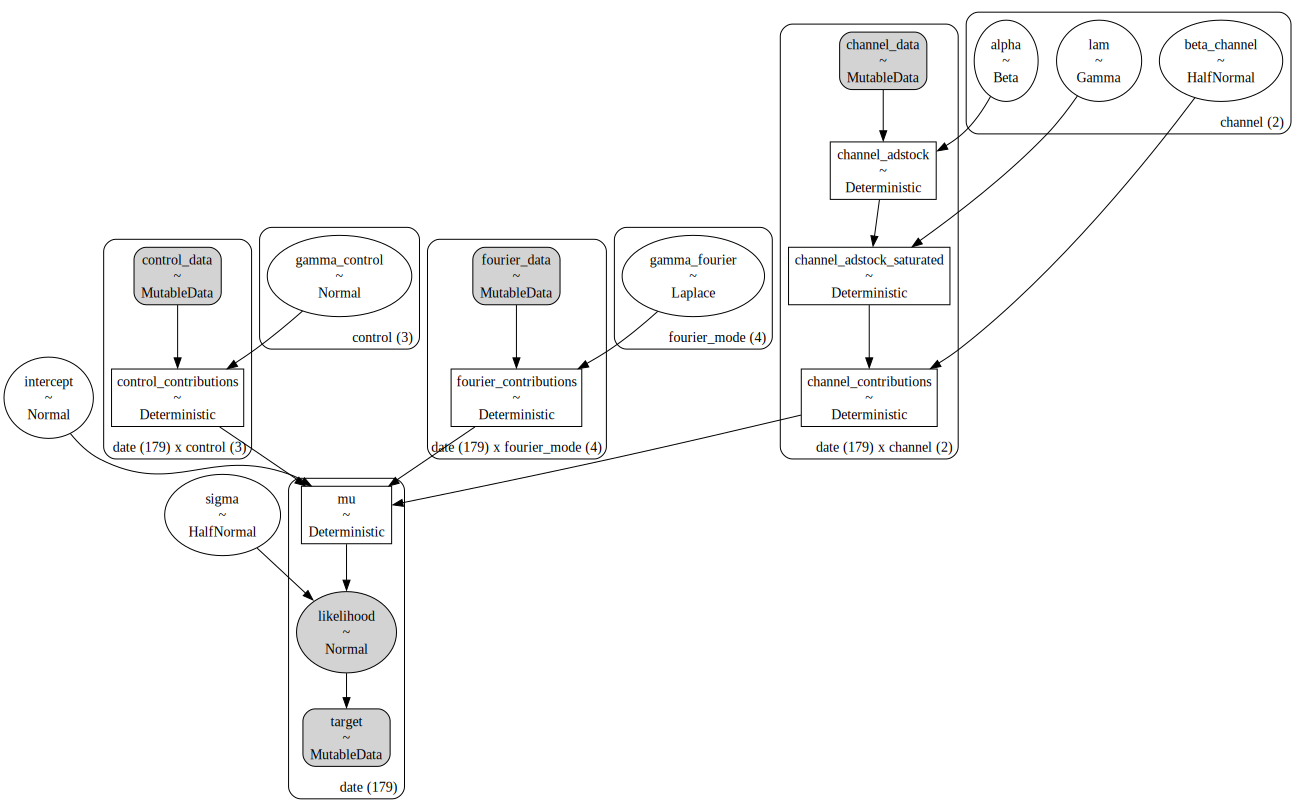

In [42]:
loaded_model.graphviz()